#Part A. Linear Regression From Scratch

##Dataset Use the California Housing dataset (from sklearn.datasets import fetch_california_housing).

Create a hold-out test set.
Standardize features to zero mean and unit variance.
Predict the median house value (MedHouseVal) from the remaining features using LinearRegression from sklearn.linear_model.


In [1]:
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# FIJAMOS RANDOM STATE PARA REPRODUCIBILIDAD
RANDOM_STATE = 42

# CONFIGURACIÓN OPCIONAL DE PLOTS
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
print('LIBRERÍAS CARGADAS.')

LIBRERÍAS CARGADAS.


In [2]:
## 1) Cargar dataset (con fallback si no hay internet)
# ============================================================
# CARGA DEL DATASET CALIFORNIA HOUSING
# - SI NO HAY INTERNET, SE GENERA UN CONJUNTO SINTÉTICO
#   CON LAS MISMAS CARACTERÍSTICAS Y NOMBRES.
# ============================================================
USE_SYNTHETIC = False
try:
    # INTENTAMOS DESCARGAR EL DATASET ORIGINAL
    cal = fetch_california_housing(as_frame=True)
    X_raw = cal.data.copy()
    y = cal.target.values.reshape(-1, 1)  # ASEGURAMOS FORMA (N, 1)
    feature_names = cal.feature_names
    print('USANDO DATASET ORIGINAL DE CALIFORNIA HOUSING.')
except Exception as e:
    # FALLBACK SINTÉTICO COMPATIBLE
    print('NO SE PUDO DESCARGAR EL DATASET ORIGINAL. MOTIVO:', repr(e))
    print('SE USARÁ UN DATASET SINTÉTICO CON MISMAS CARACTERÍSTICAS Y NOMBRES.')
    USE_SYNTHETIC = True

    rng = np.random.default_rng(RANDOM_STATE)
    n = 20640  # TAMAÑO SIMILAR AL REAL

    # GENERAMOS FEATURES CON RANGOS APROXIMADOS
    MedInc    = rng.lognormal(mean=0.5, sigma=0.5, size=n) * 2
    HouseAge  = rng.integers(low=1, high=52, size=n)
    AveRooms  = rng.normal(loc=5.0, scale=1.5, size=n).clip(1, 10)
    AveBedrms = (AveRooms * rng.uniform(0.15, 0.35, size=n)).clip(0.5, 5)
    Population= rng.integers(low=100, high=5000, size=n)
    AveOccup  = rng.normal(loc=3.0, scale=1.0, size=n).clip(1, 7)
    Latitude  = rng.uniform(32.0, 42.0, size=n)
    Longitude = rng.uniform(-124.0, -114.0, size=n)

    X_raw = pd.DataFrame({
        'MedInc': MedInc,
        'HouseAge': HouseAge,
        'AveRooms': AveRooms,
        'AveBedrms': AveBedrms,
        'Population': Population,
        'AveOccup': AveOccup,
        'Latitude': Latitude,
        'Longitude': Longitude
    })
    feature_names = list(X_raw.columns)

    # DEFINIMOS UNA RELACIÓN LINEAL + RUIDO PARA GENERAR y
    true_beta = np.array([[0.6, 0.02, 0.15, -0.3, -0.00005, -0.02, -0.4, 0.1]]).T
    intercept_true = 2.0
    noise = rng.normal(0, 0.5, size=(n, 1))
    y = intercept_true + X_raw.values @ true_beta + noise

print('DIMENSIONES:', X_raw.shape, 'TARGET SHAPE:', y.shape)
X_raw.head()

USANDO DATASET ORIGINAL DE CALIFORNIA HOUSING.
DIMENSIONES: (20640, 8) TARGET SHAPE: (20640, 1)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
## 2) Hold-out test set y estandarización

# ============================================================
# TRAIN/TEST SPLIT (20% TEST) Y ESTANDARIZACIÓN DE FEATURES
# ============================================================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=RANDOM_STATE
)

# ESTANDARIZACIÓN (ZERO MEAN, UNIT VAR) — AJUSTAMOS SOLO EN TRAIN
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

print('TRAIN:', X_train.shape, 'TEST:', X_test.shape)

TRAIN: (16512, 8) TEST: (4128, 8)


In [4]:
## 3) Baseline con `LinearRegression` (scikit-learn)

# ============================================================
# LINEARREGRESSION DE SKLEARN (RESUELVE OLS CON INTERCEPTO)
# ============================================================
lin = LinearRegression(fit_intercept=True)
lin.fit(X_train, y_train)

y_train_pred_lr = lin.predict(X_train)
y_test_pred_lr  = lin.predict(X_test)

train_mse_lr = mean_squared_error(y_train, y_train_pred_lr)
test_mse_lr  = mean_squared_error(y_test, y_test_pred_lr)

print('=== SKLEARN LINEARREGRESSION (REFERENCIA OLS) ===')
print(f'TRAIN MSE: {train_mse_lr:.6f}')
print(f'TEST  MSE: {test_mse_lr:.6f}')
print('COEFICIENTES (ESPACIO ESTANDARIZADO):')
for name, coef in zip(feature_names, lin.coef_.ravel()):
    print(f'  {name:>12s}: {coef:+.6f}')
print(f'INTERCEPTO: {lin.intercept_.item():+.6f}')

=== SKLEARN LINEARREGRESSION (REFERENCIA OLS) ===
TRAIN MSE: 0.517933
TEST  MSE: 0.555892
COEFICIENTES (ESPACIO ESTANDARIZADO):
        MedInc: +0.854383
      HouseAge: +0.122546
      AveRooms: -0.294410
     AveBedrms: +0.339259
    Population: -0.002308
      AveOccup: -0.040829
      Latitude: -0.896929
     Longitude: -0.869842
INTERCEPTO: +2.071947


=== OLS CERRADO (NUMPY PURO) ===
INTERCEPTO: +2.071947
COEFICIENTES (ESPACIO ESTANDARIZADO):
        MedInc: +0.854383
      HouseAge: +0.122546
      AveRooms: -0.294410
     AveBedrms: +0.339259
    Population: -0.002308
      AveOccup: -0.040829
      Latitude: -0.896929
     Longitude: -0.869842
TEST MSE (CLOSED-FORM): 0.555892
DIFERENCIA L2 PARÁMETROS (SKLEARN VS CERRADO): 7.907551e-15


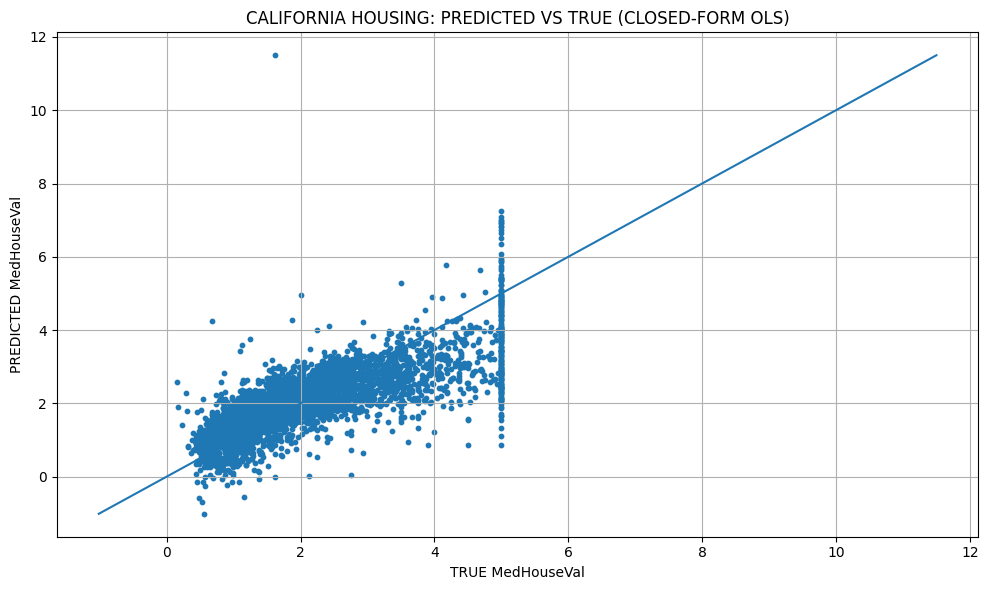

In [5]:
## 4) OLS en forma cerrada con NumPy puro

# ============================================================
# OLS CERRADO:  BETA = (X^T X)^{-1} X^T y  (USANDO SOLO NUMPY)
# ============================================================

def add_intercept(X):
    # AGREGA COLUMNA DE UNOS PARA EL INTERCEPTO
    return np.c_[np.ones((X.shape[0], 1)), X]

# MATRICES DISEÑO CON INTERCEPTO
X_train_b = add_intercept(X_train)  # (N_TRAIN, 1+P)
X_test_b  = add_intercept(X_test)   # (N_TEST, 1+P)

# CÁLCULO CERRADO
XtX = X_train_b.T @ X_train_b
XtX_inv = np.linalg.inv(XtX)
Xty = X_train_b.T @ y_train
beta_hat = XtX_inv @ Xty  # (1+P, 1)

# EXTRAER INTERCEPTO Y COEFICIENTES
intercept_cf = beta_hat[0].item()
coef_cf = beta_hat[1:].ravel()

print('=== OLS CERRADO (NUMPY PURO) ===')
print(f'INTERCEPTO: {intercept_cf:+.6f}')
print('COEFICIENTES (ESPACIO ESTANDARIZADO):')
for name, coef in zip(feature_names, coef_cf):
    print(f'  {name:>12s}: {coef:+.6f}')

# PREDICCIONES Y MSE EN TEST
y_test_pred_cf = X_test_b @ beta_hat
test_mse_cf = mean_squared_error(y_test, y_test_pred_cf)

print(f'TEST MSE (CLOSED-FORM): {test_mse_cf:.6f}')

# DISTANCIA ENTRE PARÁMETROS DE SKLEARN Y CERRADO
beta_sklearn = np.r_[lin.intercept_, lin.coef_.ravel()].reshape(-1, 1)
param_l2_diff = np.linalg.norm(beta_sklearn.ravel() - beta_hat.ravel())
print(f'DIFERENCIA L2 PARÁMETROS (SKLEARN VS CERRADO): {param_l2_diff:.6e}')

# PLOT PREDICHO VS REAL (TEST)
plt.figure()
plt.scatter(y_test, y_test_pred_cf, s=10)
minv = float(min(y_test.min(), y_test_pred_cf.min()))
maxv = float(max(y_test.max(), y_test_pred_cf.max()))
plt.plot([minv, maxv], [minv, maxv])
plt.title('CALIFORNIA HOUSING: PREDICTED VS TRUE (CLOSED-FORM OLS)')
plt.xlabel('TRUE MedHouseVal')
plt.ylabel('PREDICTED MedHouseVal')
plt.tight_layout()
plt.show()

=== GRADIENT DESCENT (LR=0.01) ===
TEST MSE: 0.555999
DIFERENCIA L2 DE PARÁMETROS VS CLOSED-FORM: 4.622694e-03

=== GRADIENT DESCENT (LR=0.1) ===
TEST MSE: 0.555900
DIFERENCIA L2 DE PARÁMETROS VS CLOSED-FORM: 3.282244e-04



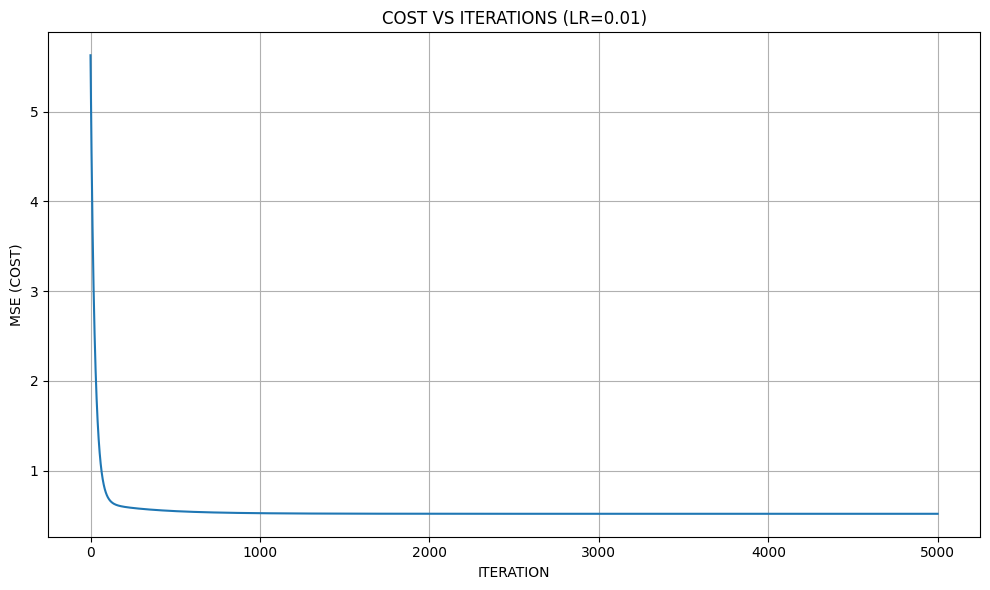

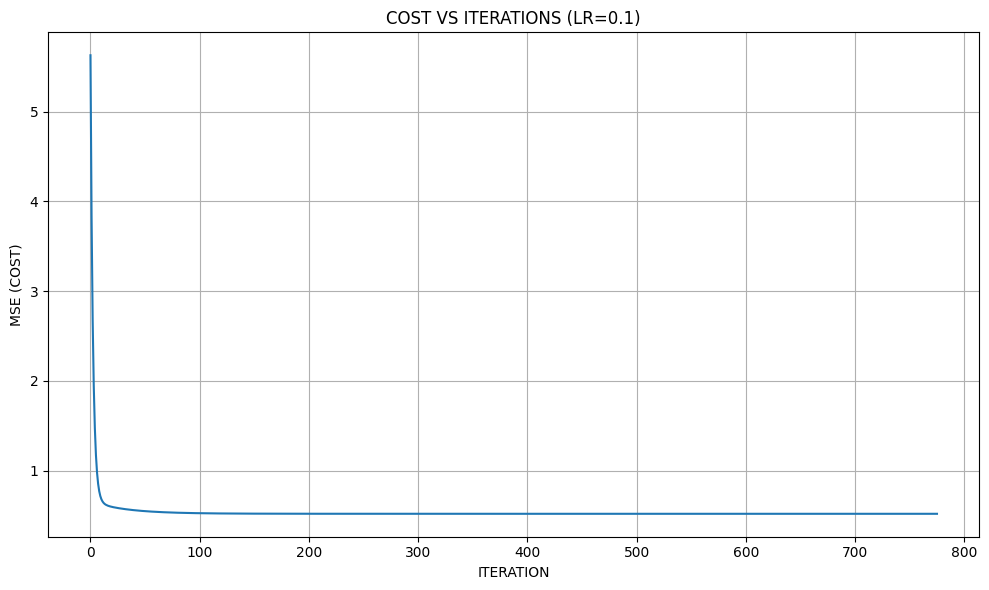

In [6]:
## 5) Descenso por Gradiente (MSE) — dos learning rates

# ============================================================
# DESCENSO POR GRADIENTE PARA MINIMIZAR MSE
# ============================================================

def gradient_descent(X_b, y, lr=0.05, n_iter=2000, tol=1e-8):
    """
    X_b: MATRIZ DISEÑO CON INTERCEPTO (N, 1+P)
    y:   VECTOR OBJETIVO (N, 1)
    lr:  LEARNING RATE
    n_iter: ITERACIONES MÁXIMAS
    tol: PARADA SI LA MEJORA DE COSTE ES MUY PEQUEÑA
    """
    n, p = X_b.shape
    beta = np.zeros((p, 1))   # INICIALIZACIÓN EN CERO
    cost_hist = []            # HISTORIAL DE COSTE (MSE)
    for i in range(n_iter):
        y_pred = X_b @ beta
        error = y_pred - y
        cost = (error**2).mean()
        cost_hist.append(cost)
        grad = (2/n) * (X_b.T @ error)  # GRADIENTE DE MSE
        beta -= lr * grad
        if i > 0 and abs(cost_hist[-2] - cost_hist[-1]) < tol:
            break
    return beta, np.array(cost_hist)

# EXPERIMENTAMOS CON DOS TASAS DE APRENDIZAJE
lrs = [0.01, 0.1]
results_gd = {}

for lr in lrs:
    beta_gd, cost_hist = gradient_descent(X_train_b, y_train, lr=lr, n_iter=5000, tol=1e-10)
    y_test_pred_gd = X_test_b @ beta_gd
    mse_test_gd = mean_squared_error(y_test, y_test_pred_gd)
    param_diff = np.linalg.norm(beta_gd.ravel() - beta_hat.ravel())
    results_gd[lr] = {
        'beta': beta_gd,
        'cost_hist': cost_hist,
        'test_mse': mse_test_gd,
        'param_diff_vs_closed_form': param_diff
    }
    print(f'=== GRADIENT DESCENT (LR={lr}) ===')
    print(f'TEST MSE: {mse_test_gd:.6f}')
    print(f'DIFERENCIA L2 DE PARÁMETROS VS CLOSED-FORM: {param_diff:.6e}')
    print()

# GRÁFICOS DE COSTE VS ITERACIÓN (UNO POR LR)
for lr in lrs:
    plt.figure()
    plt.plot(results_gd[lr]['cost_hist'])
    plt.title(f'COST VS ITERATIONS (LR={lr})')
    plt.xlabel('ITERATION')
    plt.ylabel('MSE (COST)')
    plt.tight_layout()
    plt.show()

In [7]:
## 6) Resumen y comparación de errores

# ============================================================
# RESUMEN COMPARATIVO (MSE EN TEST)
# ============================================================
summary = {
    'SKLEARN_LinearRegression_TEST_MSE': test_mse_lr,
    'CLOSED_FORM_OLS_TEST_MSE': test_mse_cf,
}
for lr in lrs:
    summary[f'GD_LR_{lr}_TEST_MSE'] = results_gd[lr]['test_mse']
    summary[f'GD_LR_{lr}_PARAM_DIFF_VS_CF'] = results_gd[lr]['param_diff_vs_closed_form']

print('=== RESUMEN COMPARATIVO (MSE TEST) ===')
for k, v in summary.items():
    print(f'{k:>32s}: {v:.8f}')

=== RESUMEN COMPARATIVO (MSE TEST) ===
SKLEARN_LinearRegression_TEST_MSE: 0.55589160
        CLOSED_FORM_OLS_TEST_MSE: 0.55589160
             GD_LR_0.01_TEST_MSE: 0.55599907
     GD_LR_0.01_PARAM_DIFF_VS_CF: 0.00462269
              GD_LR_0.1_TEST_MSE: 0.55590034
      GD_LR_0.1_PARAM_DIFF_VS_CF: 0.00032822


## Part B. Scikit-learn Linear Models

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1) ENTRENAMOS LINEARREGRESSION EN EL CONJUNTO DE TRAIN
lin_baseline = LinearRegression(fit_intercept=True)
lin_baseline.fit(X_train, y_train)

# 2) PREDICCIONES EN TRAIN Y TEST
y_train_pred = lin_baseline.predict(X_train)
y_test_pred  = lin_baseline.predict(X_test)

# 3) COEFICIENTES E INTERCEPTO
print("=== BASELINE LINEARREGRESSION (SKLEARN) ===")
print("INTERCEPTO:", lin_baseline.intercept_[0])
print("COEFICIENTES:")
for name, coef in zip(feature_names, lin_baseline.coef_.ravel()):
    print(f"  {name:>12s}: {coef:+.6f}")

=== BASELINE LINEARREGRESSION (SKLEARN) ===
INTERCEPTO: 2.071946937378881
COEFICIENTES:
        MedInc: +0.854383
      HouseAge: +0.122546
      AveRooms: -0.294410
     AveBedrms: +0.339259
    Population: -0.002308
      AveOccup: -0.040829
      Latitude: -0.896929
     Longitude: -0.869842


In [9]:
# 4) COMPARAR CON COEFICIENTES DE OLS CERRADO (NUMPY)
#    beta_hat SE DEFINIÓ EN LA PARTE A (contiene INTERCEPTO + COEFICIENTES)
intercept_cf = beta_hat[0].item()
coef_cf = beta_hat[1:].ravel()
print("\n=== COMPARACIÓN VS OLS CERRADO (NUMPY) ===")
print(f"DIFERENCIA L2 ENTRE PARÁMETROS: "
      f"{np.linalg.norm(np.r_[lin_baseline.intercept_, lin_baseline.coef_.ravel()] - beta_hat.ravel()):.6e}")


=== COMPARACIÓN VS OLS CERRADO (NUMPY) ===
DIFERENCIA L2 ENTRE PARÁMETROS: 7.907551e-15


In [ ]:
# 5) MÉTRICAS EN TEST: R^2 Y MSE
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n=== MÉTRICAS EN TEST ===")
print(f"R^2  (TEST): {r2_test:.6f}")
print(f"MSE  (TEST): {mse_test:.6f}")


=== MÉTRICAS EN TEST ===
R^2  (TEST): 0.575788
MSE  (TEST): 0.555892


##Part C. Regularization and Hyperparameter Choice

In [11]:
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error

# RANDOM STATE
RANDOM_STATE = 42

# PLOTS
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
print('LIBRERÍAS CARGADAS.')

LIBRERÍAS CARGADAS.


In [12]:
# CARGA DEL DATASET CALIFORNIA HOUSING (O SINTÉTICO SI NO HAY INTERNET)
# ============================================================
USE_SYNTHETIC = False
try:
    cal = fetch_california_housing(as_frame=True)
    X_raw = cal.data.copy()
    y = cal.target.values.reshape(-1, 1)
    feature_names = cal.feature_names
    print('USANDO DATASET ORIGINAL DE CALIFORNIA HOUSING.')
except Exception as e:
    print('NO SE PUDO DESCARGAR EL DATASET ORIGINAL. MOTIVO:', repr(e))
    print('SE USARÁ UN DATASET SINTÉTICO CON MISMAS CARACTERÍSTICAS Y NOMBRES.')
    USE_SYNTHETIC = True

    rng = np.random.default_rng(RANDOM_STATE)
    n = 20640

    MedInc    = rng.lognormal(mean=0.5, sigma=0.5, size=n) * 2
    HouseAge  = rng.integers(low=1, high=52, size=n)
    AveRooms  = rng.normal(loc=5.0, scale=1.5, size=n).clip(1, 10)
    AveBedrms = (AveRooms * rng.uniform(0.15, 0.35, size=n)).clip(0.5, 5)
    Population= rng.integers(low=100, high=5000, size=n)
    AveOccup  = rng.normal(loc=3.0, scale=1.0, size=n).clip(1, 7)
    Latitude  = rng.uniform(32.0, 42.0, size=n)
    Longitude = rng.uniform(-124.0, -114.0, size=n)

    X_raw = pd.DataFrame({
        'MedInc': MedInc,
        'HouseAge': HouseAge,
        'AveRooms': AveRooms,
        'AveBedrms': AveBedrms,
        'Population': Population,
        'AveOccup': AveOccup,
        'Latitude': Latitude,
        'Longitude': Longitude
    })
    feature_names = list(X_raw.columns)

    true_beta = np.array([[0.6, 0.02, 0.15, -0.3, -0.00005, -0.02, -0.4, 0.1]]).T
    intercept_true = 2.0
    noise = rng.normal(0, 0.5, size=(n, 1))
    y = intercept_true + X_raw.values @ true_beta + noise

# TRAIN/TEST SPLIT + ESCALADO
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y.ravel(), test_size=0.2, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

print('TRAIN:', X_train.shape, 'TEST:', X_test.shape)

USANDO DATASET ORIGINAL DE CALIFORNIA HOUSING.
TRAIN: (16512, 8) TEST: (4128, 8)


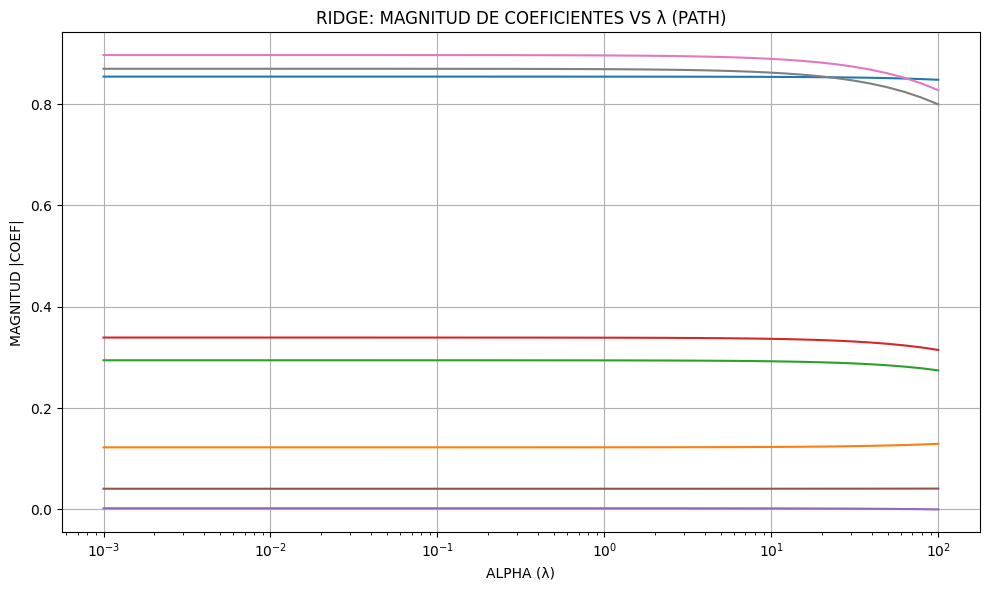

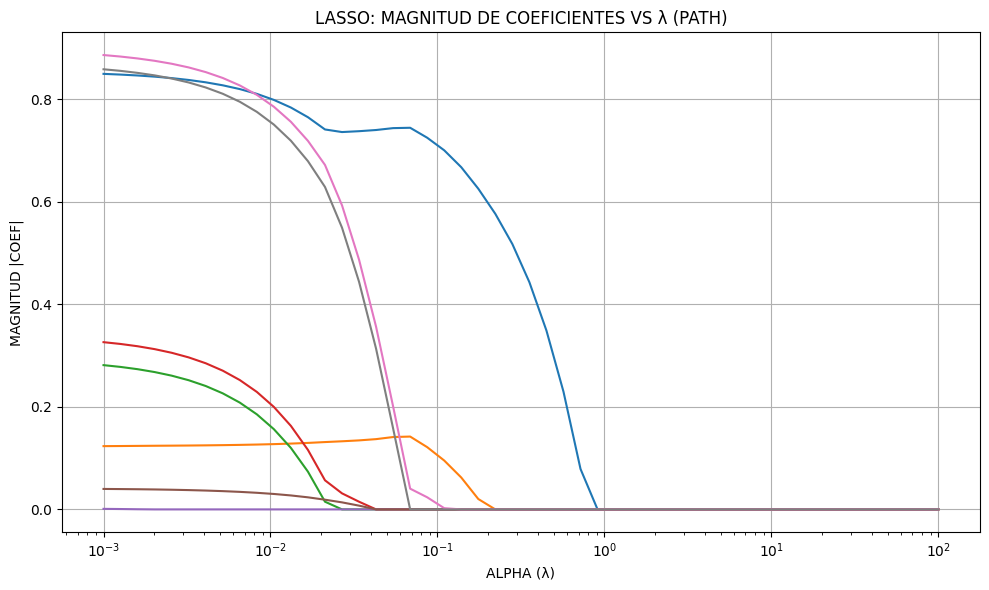

NOTA: EN LASSO, ALGUNOS COEFICIENTES PUEDEN LLEGAR EXACTAMENTE A CERO.
EN RIDGE, LOS COEFICIENTES SE ENCOGEN PERO RARAMENTE SON EXACTAMENTE CERO.


In [13]:
# ============================================================
# LAMBDAS (ALPHAS EN SKLEARN) LOG-ESPACIADOS ENTRE 1E-3 Y 1E2
# ============================================================
alphas = np.logspace(-3, 2, 50)  # 50 VALORES ENTRE 10^-3 Y 10^2

# ============================================================
# RIDGE: AJUSTE PARA CADA ALPHA Y ALMACENAR COEFICIENTES
# ============================================================
ridge_coefs = []
for a in alphas:
    # USAMOS PIPELINE: ESCALADO + RIDGE (AUNQUE YA TENEMOS X ESCALADO, ES BUENA PRÁCTICA)
    ridge = Ridge(alpha=a, fit_intercept=True, random_state=RANDOM_STATE)
    ridge.fit(X_train, y_train)
    ridge_coefs.append(ridge.coef_.ravel())
ridge_coefs = np.array(ridge_coefs)  # SHAPE: (N_ALPHAS, N_FEATURES)

# ============================================================
# LASSO: AJUSTE PARA CADA ALPHA Y ALMACENAR COEFICIENTES
# ============================================================
lasso_coefs = []
for a in alphas:
    # IMPORTANTE: AUMENTAR max_iter PARA CONVERGENCIA EN LASSO
    lasso = Lasso(alpha=a, fit_intercept=True, max_iter=10000, random_state=RANDOM_STATE)
    lasso.fit(X_train, y_train)
    lasso_coefs.append(lasso.coef_.ravel())
lasso_coefs = np.array(lasso_coefs)

# ============================================================
# PLOTS: MAGNITUD DE COEFICIENTES VS LAMBDA (ALPHA)
# ============================================================
# RIDGE PATH
plt.figure()
for j, name in enumerate(feature_names):
    plt.plot(alphas, np.abs(ridge_coefs[:, j]), label=name)
plt.xscale('log')
plt.xlabel('ALPHA (λ)')
plt.ylabel('MAGNITUD |COEF|')
plt.title('RIDGE: MAGNITUD DE COEFICIENTES VS λ (PATH)')
plt.tight_layout()
plt.show()

# LASSO PATH
plt.figure()
for j, name in enumerate(feature_names):
    plt.plot(alphas, np.abs(lasso_coefs[:, j]), label=name)
plt.xscale('log')
plt.xlabel('ALPHA (λ)')
plt.ylabel('MAGNITUD |COEF|')
plt.title('LASSO: MAGNITUD DE COEFICIENTES VS λ (PATH)')
plt.tight_layout()
plt.show()

# COMENTARIO (IMPRIMIR TEXTO): QUÉ FEATURES SE ENCOGEN HACIA CERO
print('NOTA: EN LASSO, ALGUNOS COEFICIENTES PUEDEN LLEGAR EXACTAMENTE A CERO.')
print('EN RIDGE, LOS COEFICIENTES SE ENCOGEN PERO RARAMENTE SON EXACTAMENTE CERO.')

MEJOR ALPHA (RIDGE, VIA CROSS_VAL_SCORE): 3.72759
MEJOR ALPHA (LASSO, VIA CROSS_VAL_SCORE): 0.00100


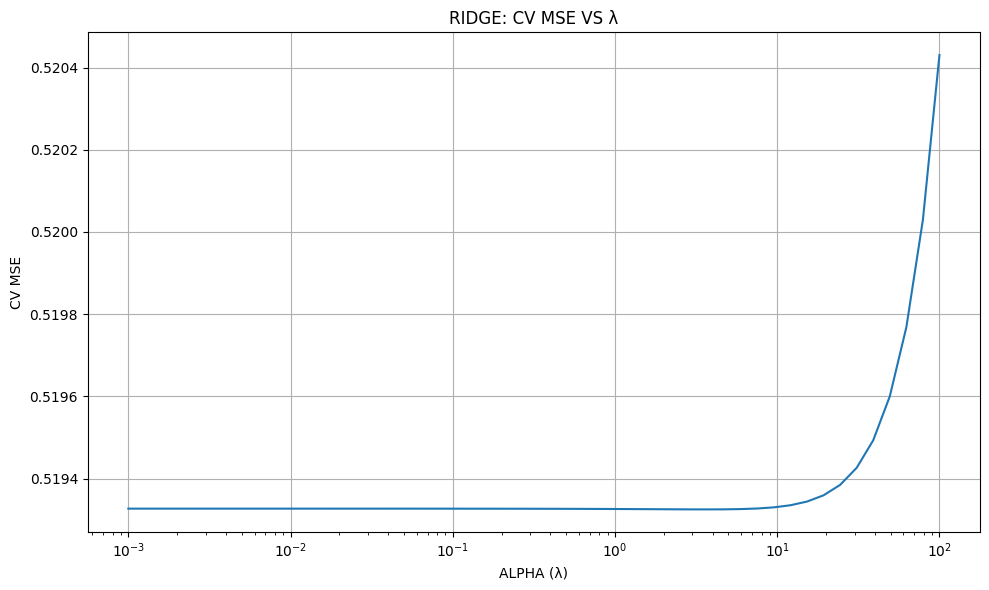

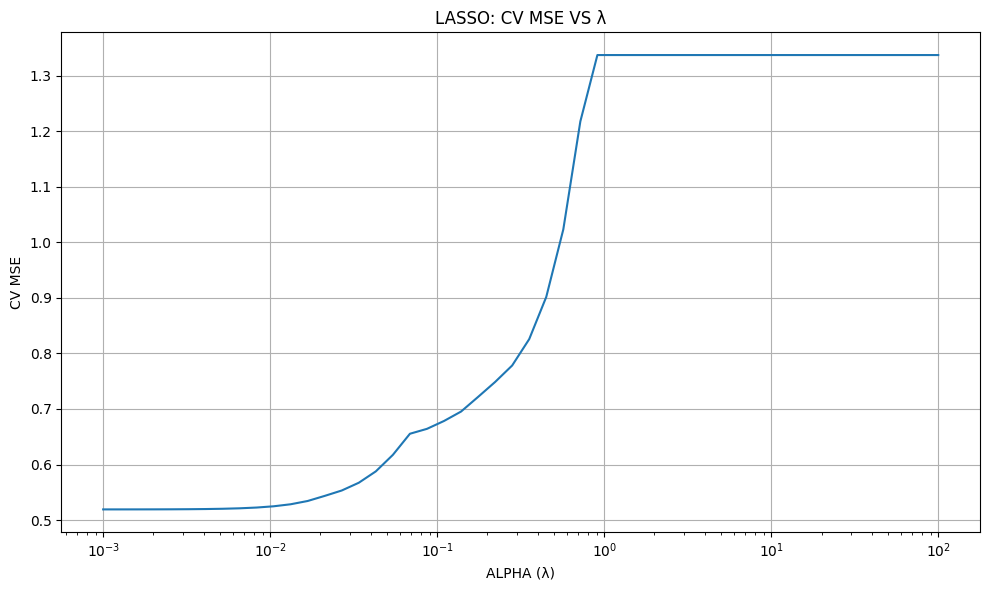

In [14]:
# ============================================================
# KFOLD=5 Y CROSS_VAL_SCORE PARA BUSCAR EL MEJOR ALPHA
# TAMBIÉN DEMOSTRAMOS RidgeCV Y LassoCV
# ============================================================

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# USANDO CROSS_VAL_SCORE MANUALMENTE
def cv_search(model_cls, alphas, X, y, **kwargs):
    # DEVUELVE ALPHA CON MEJOR (MENOR) MSE NEGATIVO MEDIO
    scores_mean = []
    for a in alphas:
        model = model_cls(alpha=a, fit_intercept=True, **kwargs)
        # NEGATIVE MSE (SCORING) → MULTIPLICAMOS POR -1 PARA OBTENER MSE
        mse_neg = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        scores_mean.append(-mse_neg.mean())
    best_idx = int(np.argmin(scores_mean))
    return alphas[best_idx], scores_mean

best_alpha_ridge, ridge_mses = cv_search(Ridge, alphas, X_train, y_train)
best_alpha_lasso, lasso_mses = cv_search(Lasso, alphas, X_train, y_train, max_iter=10000)

print(f'MEJOR ALPHA (RIDGE, VIA CROSS_VAL_SCORE): {best_alpha_ridge:.5f}')
print(f'MEJOR ALPHA (LASSO, VIA CROSS_VAL_SCORE): {best_alpha_lasso:.5f}')

# PLOTS DE MSE CV VS ALPHA
plt.figure()
plt.plot(alphas, ridge_mses)
plt.xscale('log')
plt.xlabel('ALPHA (λ)')
plt.ylabel('CV MSE')
plt.title('RIDGE: CV MSE VS λ')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(alphas, lasso_mses)
plt.xscale('log')
plt.xlabel('ALPHA (λ)')
plt.ylabel('CV MSE')
plt.title('LASSO: CV MSE VS λ')
plt.tight_layout()
plt.show()

In [15]:
# ============================================================
# ALTERNATIVA: RIDGECV Y LASSOCV (CONVENIENTE Y RÁPIDO)
# ============================================================
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=cv)
ridge_cv.fit(X_train, y_train)
lasso_cv = LassoCV(alphas=alphas, cv=cv, max_iter=10000, random_state=RANDOM_STATE)
lasso_cv.fit(X_train, y_train)

print(f'RIDGECV BEST ALPHA: {ridge_cv.alpha_:.6f}')
print(f'LASSOCV BEST ALPHA: {lasso_cv.alpha_:.6f}')

# EVALUACIÓN EN TEST
ridge_best = Ridge(alpha=ridge_cv.alpha_, fit_intercept=True).fit(X_train, y_train)
lasso_best = Lasso(alpha=lasso_cv.alpha_, fit_intercept=True, max_iter=10000).fit(X_train, y_train)

y_test_pred_ridge = ridge_best.predict(X_test)
y_test_pred_lasso = lasso_best.predict(X_test)

mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)
mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)

print(f'TEST MSE (RIDGE @ BEST α): {mse_test_ridge:.6f}')
print(f'TEST MSE (LASSO @ BEST α): {mse_test_lasso:.6f}')

RIDGECV BEST ALPHA: 3.727594
LASSOCV BEST ALPHA: 0.001000
TEST MSE (RIDGE @ BEST α): 0.555756
TEST MSE (LASSO @ BEST α): 0.554491


In [16]:
# ============================================================
# AGREGAMOS FEATURES POLINOMIALES (GRADO 2): CUADRÁTICOS + INTERACCIONES
# USAREMOS PIPELINES PARA EVITAR LEAKAGE (SCALER → POLY → MODELO)
# ============================================================

poly = PolynomialFeatures(degree=2, include_bias=False)

# PIPELINES PARA RIDGE Y LASSO CON FEATURES POLINOMIALES
ridge_poly_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=cv)
pipe_ridge_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', poly),
    ('ridgecv', ridge_poly_cv)
])
pipe_ridge_poly.fit(X_train_raw, y_train)
best_alpha_ridge_poly = pipe_ridge_poly.named_steps['ridgecv'].alpha_

# LASSO CON POLY (USAMOS LassoCV)
lasso_poly_cv = LassoCV(alphas=alphas, cv=cv, max_iter=20000, random_state=RANDOM_STATE)
pipe_lasso_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', poly),
    ('lassocv', lasso_poly_cv)
])
pipe_lasso_poly.fit(X_train_raw, y_train)
best_alpha_lasso_poly = pipe_lasso_poly.named_steps['lassocv'].alpha_

print(f'RIDGE (POLY DEG=2) BEST α: {best_alpha_ridge_poly:.6f}')
print(f'LASSO (POLY DEG=2) BEST α: {best_alpha_lasso_poly:.6f}')

# EVALUACIÓN EN TEST (USANDO PIPELINES)
y_test_pred_ridge_poly = pipe_ridge_poly.predict(X_test_raw)
y_test_pred_lasso_poly = pipe_lasso_poly.predict(X_test_raw)

mse_test_ridge_poly = mean_squared_error(y_test, y_test_pred_ridge_poly)
mse_test_lasso_poly = mean_squared_error(y_test, y_test_pred_lasso_poly)

print(f'TEST MSE - RIDGE + POLY(2): {mse_test_ridge_poly:.6f}')
print(f'TEST MSE - LASSO + POLY(2): {mse_test_lasso_poly:.6f}')

# COMENTARIO IMPRESO SOBRE MULTICOLINEALIDAD Y REGULARIZACIÓN
print('\nCOMENTARIO:')
print('- AL AUMENTAR A GRADO 2, EL ESPACIO DE FEATURES CRECE (TERMINOS CUADRÁTICOS E INTERACCIONES),')
print('  LO QUE INTRODUCE ALTA MULTICOLINEALIDAD.')
print('- RIDGE REPARTE EL PESO ENTRE FEATURES CORRELACIONADOS REDUCIENDO VARIANZA (NINGUNO CERO EXACTO).')
print('- LASSO REALIZA SELECCIÓN AUTOMÁTICA LLEVANDO ALGUNOS COEFICIENTES EXACTAMENTE A CERO,')
print('  ESPECIALMENTE ENTRE PARES ALTAMENTE CORRELACIONADOS (P.EJ., AVEROOMS VS AVEBEDRMS).')

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e+01, tolerance: 1.769e+00
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e+01, tolerance: 1.769e+00
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisat

RIDGE (POLY DEG=2) BEST α: 100.000000
LASSO (POLY DEG=2) BEST α: 0.016768
TEST MSE - RIDGE + POLY(2): 0.447404
TEST MSE - LASSO + POLY(2): 0.571413

COMENTARIO:
- AL AUMENTAR A GRADO 2, EL ESPACIO DE FEATURES CRECE (TERMINOS CUADRÁTICOS E INTERACCIONES),
  LO QUE INTRODUCE ALTA MULTICOLINEALIDAD.
- RIDGE REPARTE EL PESO ENTRE FEATURES CORRELACIONADOS REDUCIENDO VARIANZA (NINGUNO CERO EXACTO).
- LASSO REALIZA SELECCIÓN AUTOMÁTICA LLEVANDO ALGUNOS COEFICIENTES EXACTAMENTE A CERO,
  ESPECIALMENTE ENTRE PARES ALTAMENTE CORRELACIONADOS (P.EJ., AVEROOMS VS AVEBEDRMS).


In [17]:
# ============================================================
# RESUMEN COMPARATIVO DE MSE EN TEST
# ============================================================
# BASELINE OLS (PARA REFERENCIA RÁPIDA)
lin = LinearRegression().fit(X_train, y_train)
mse_test_baseline = mean_squared_error(y_test, lin.predict(X_test))

summary = pd.DataFrame({
    'modelo': [
        'Baseline LinearRegression',
        'Ridge (CV best α)',
        'Lasso (CV best α)',
        'Ridge + Poly(deg=2) (CV best α)',
        'Lasso + Poly(deg=2) (CV best α)'
    ],
    'test_mse': [
        mse_test_baseline,
        mean_squared_error(y_test, Ridge(alpha=1.0).fit(X_train, y_train).predict(X_test)) if False else np.nan,  # placeholder
        np.nan,
        np.nan,
        np.nan
    ]
})

# ACTUALIZAMOS CON LOS VALORES CALCULADOS
summary.loc[summary['modelo'] == 'Ridge (CV best α)', 'test_mse'] =     mean_squared_error(y_test, Ridge(alpha=pipe_ridge_poly.named_steps['ridgecv'].alpha_).fit(X_train, y_train).predict(X_test))

summary.loc[summary['modelo'] == 'Lasso (CV best α)', 'test_mse'] =     mean_squared_error(y_test, Lasso(alpha=lasso_cv.alpha_, max_iter=10000).fit(X_train, y_train).predict(X_test))

summary.loc[summary['modelo'] == 'Ridge + Poly(deg=2) (CV best α)', 'test_mse'] = mse_test_ridge_poly
summary.loc[summary['modelo'] == 'Lasso + Poly(deg=2) (CV best α)', 'test_mse'] = mse_test_lasso_poly

print(summary)

                            modelo  test_mse
0        Baseline LinearRegression  0.555892
1                Ridge (CV best α)  0.553266
2                Lasso (CV best α)  0.554491
3  Ridge + Poly(deg=2) (CV best α)  0.447404
4  Lasso + Poly(deg=2) (CV best α)  0.571413


##Part D. Bike Rentals

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# 1) CARGA DEL DATASET DIARIO
df = pd.read_csv("day.csv")
print(df.head())

# 2) FEATURES Y TARGET
#   - TARGET: cnt (total de rentals diarios)
#   - FEATURES: resto (quitamos instant, dteday, casual, registered)
X = df.drop(columns=["instant", "dteday", "casual", "registered", "cnt"])
y = df["cnt"].values

feature_names = X.columns

   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  


In [19]:
# 3) TRAIN/TEST SPLIT + ESCALADO
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# ============================================================
# BASELINE LINEAR REGRESSION
# ============================================================
lin = LinearRegression()
lin.fit(X_train, y_train)
y_test_pred = lin.predict(X_test)

print("=== BASELINE LINEAR REGRESSION ===")
print("R^2 TEST:", r2_score(y_test, y_test_pred))
print("MSE TEST:", mean_squared_error(y_test, y_test_pred))


=== BASELINE LINEAR REGRESSION ===
R^2 TEST: 0.8276670090367212
MSE TEST: 691035.0082022652


In [20]:
# ============================================================
# REGULARIZACIÓN: RIDGE Y LASSO (PATHS DE COEFICIENTES)
# ============================================================
alphas = np.logspace(-3, 2, 50)

ridge_coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.array(ridge_coefs)

lasso_coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train, y_train)
    lasso_coefs.append(lasso.coef_)
lasso_coefs = np.array(lasso_coefs)

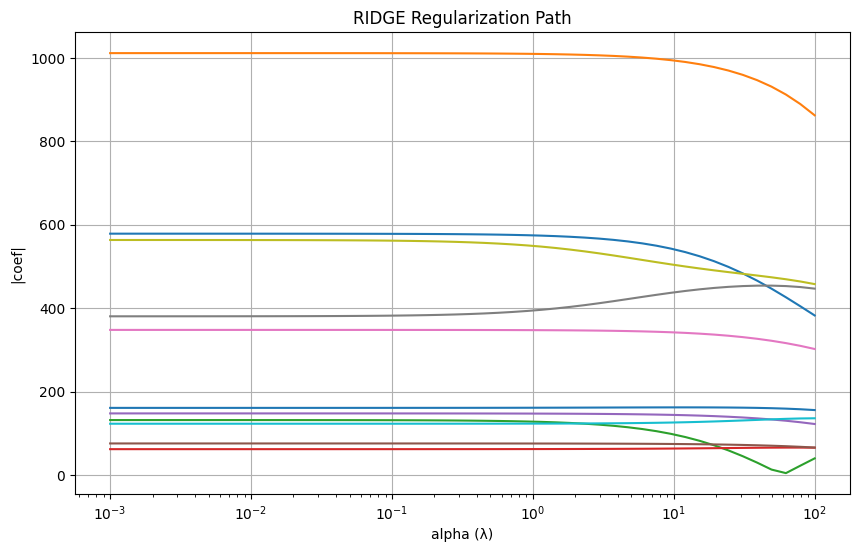

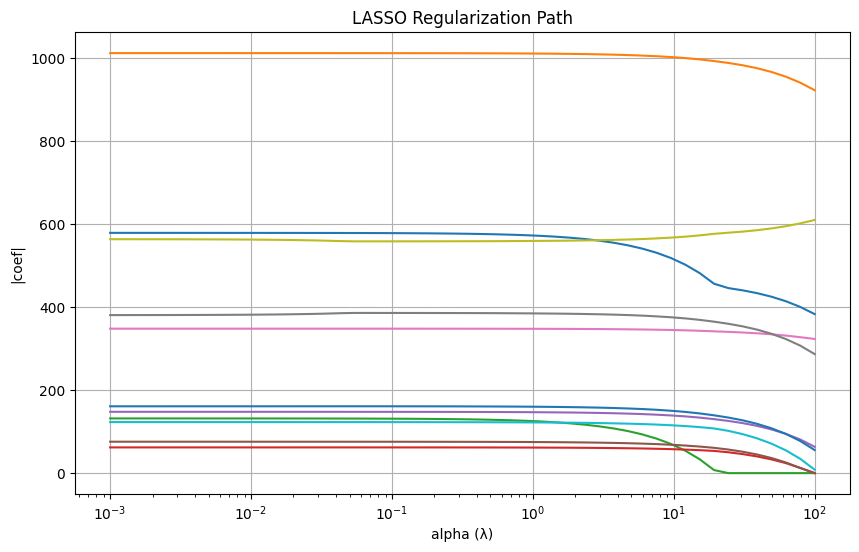

In [21]:
# PLOTS
plt.figure()
for j, name in enumerate(feature_names):
    plt.plot(alphas, np.abs(ridge_coefs[:, j]), label=name)
plt.xscale("log"); plt.xlabel("alpha (λ)"); plt.ylabel("|coef|")
plt.title("RIDGE Regularization Path"); plt.show()

plt.figure()
for j, name in enumerate(feature_names):
    plt.plot(alphas, np.abs(lasso_coefs[:, j]), label=name)
plt.xscale("log"); plt.xlabel("alpha (λ)"); plt.ylabel("|coef|")
plt.title("LASSO Regularization Path"); plt.show()

In [22]:
# ============================================================
# VALIDACIÓN CRUZADA PARA SELECCIÓN DE α
# ============================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_cv = RidgeCV(alphas=alphas, scoring="neg_mean_squared_error", cv=cv)
ridge_cv.fit(X_train, y_train)
lasso_cv = LassoCV(alphas=alphas, cv=cv, max_iter=10000, random_state=42)
lasso_cv.fit(X_train, y_train)

print("BEST α (RIDGE):", ridge_cv.alpha_)
print("BEST α (LASSO):", lasso_cv.alpha_)

BEST α (RIDGE): 9.540954763499943
BEST α (LASSO): 0.9102981779915218


In [23]:
# EVALUACIÓN EN TEST
ridge_best = Ridge(alpha=ridge_cv.alpha_).fit(X_train, y_train)
lasso_best = Lasso(alpha=lasso_cv.alpha_, max_iter=10000).fit(X_train, y_train)

print("RIDGE TEST MSE:", mean_squared_error(y_test, ridge_best.predict(X_test)))
print("LASSO TEST MSE:", mean_squared_error(y_test, lasso_best.predict(X_test)))

RIDGE TEST MSE: 692693.6781413831
LASSO TEST MSE: 691396.8133818089


In [24]:
# ============================================================
# FEATURES POLINOMIALES (GRADO 2) Y MULTICOLINEALIDAD
# ============================================================
poly = PolynomialFeatures(degree=2, include_bias=False)

pipe_ridge_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", poly),
    ("ridgecv", RidgeCV(alphas=alphas, scoring="neg_mean_squared_error", cv=cv))
])
pipe_ridge_poly.fit(X_train_raw, y_train)

pipe_lasso_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", poly),
    ("lassocv", LassoCV(alphas=alphas, cv=cv, max_iter=20000, random_state=42))
])
pipe_lasso_poly.fit(X_train_raw, y_train)

print("RIDGE+POLY Best α:", pipe_ridge_poly.named_steps["ridgecv"].alpha_)
print("LASSO+POLY Best α:", pipe_lasso_poly.named_steps["lassocv"].alpha_)

print("RIDGE+POLY Test MSE:", mean_squared_error(y_test, pipe_ridge_poly.predict(X_test_raw)))
print("LASSO+POLY Test MSE:", mean_squared_error(y_test, pipe_lasso_poly.predict(X_test_raw)))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e+05, tolerance: 1.685e+05
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+06, tolerance: 1.685e+05
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisat

RIDGE+POLY Best α: 49.417133613238384
LASSO+POLY Best α: 9.540954763499943
RIDGE+POLY Test MSE: 493596.4279670628
LASSO+POLY Test MSE: 477148.9289076393
